### Preliminary work: Importing required packages, importing parameters setting, defining functions

In [33]:
# Required packages
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import norm
import pdb
import warnings
import time
import sys
from scipy.interpolate import RegularGridInterpolator, CubicSpline
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
sys.stdout.flush()
import os
import pickle
import SolveLinSys

In [34]:
def finiteDiff(data, dim, order, dlt, cap = None):  # compute the central difference derivatives for given input and dimensions
    """
This function computes up to second order derivatives via finite difference scheme

Input arguments are:
Data: Function value grids which you want to compute derivatives
dim: specify which dimension you want to compute derivatives in
order: denotes order of the derivative
dlt: specify the intervals of finite difference scheme
cap: denotes whether you want to cap derivatives to some minimum values

By Jiaming Wang (Jiamingwang@uchicago.edu)
    """
    res = np.zeros(data.shape)
    if order == 1:                    # first order derivatives
        
        if dim == 0:                  # to first dimension

            res[1:-1,:,:] = (1 / (2 * dlt)) * (data[2:,:,:] - data[:-2,:,:])
            res[-1,:,:] = (1 / dlt) * (data[-1,:,:] - data[-2,:,:])
            res[0,:,:] = (1 / dlt) * (data[1,:,:] - data[0,:,:])

        elif dim == 1:                # to second dimension

            res[:,1:-1,:] = (1 / (2 * dlt)) * (data[:,2:,:] - data[:,:-2,:])
            res[:,-1,:] = (1 / dlt) * (data[:,-1,:] - data[:,-2,:])
            res[:,0,:] = (1 / dlt) * (data[:,1,:] - data[:,0,:])

        elif dim == 2:                # to third dimension

            res[:,:,1:-1] = (1 / (2 * dlt)) * (data[:,:,2:] - data[:,:,:-2])
            res[:,:,-1] = (1 / dlt) * (data[:,:,-1] - data[:,:,-2])
            res[:,:,0] = (1 / dlt) * (data[:,:,1] - data[:,:,0])

        else:
            raise ValueError('wrong dim')
            
    elif order == 2:
        
        if dim == 0:                  # to first dimension

            res[1:-1,:,:] = (1 / dlt ** 2) * (data[2:,:,:] + data[:-2,:,:] - 2 * data[1:-1,:,:])
            res[-1,:,:] = (1 / dlt ** 2) * (data[-1,:,:] + data[-3,:,:] - 2 * data[-2,:,:])
            res[0,:,:] = (1 / dlt ** 2) * (data[2,:,:] + data[0,:,:] - 2 * data[1,:,:])

        elif dim == 1:                # to second dimension

            res[:,1:-1,:] = (1 / dlt ** 2) * (data[:,2:,:] + data[:,:-2,:] - 2 * data[:,1:-1,:])
            res[:,-1,:] = (1 / dlt ** 2) * (data[:,-1,:] + data[:,-3,:] - 2 * data[:,-2,:])
            res[:,0,:] = (1 / dlt ** 2) * (data[:,2,:] + data[:,0,:] - 2 * data[:,1,:])

        elif dim == 2:                # to third dimension

            res[:,:,1:-1] = (1 / dlt ** 2) * (data[:,:,2:] + data[:,:,:-2] - 2 * data[:,:,1:-1])
            res[:,:,-1] = (1 / dlt ** 2) * (data[:,:,-1] + data[:,:,-3] - 2 * data[:,:,-2])
            res[:,:,0] = (1 / dlt ** 2) * (data[:,:,2] + data[:,:,0] - 2 * data[:,:,1])

        else:
            raise ValueError('wrong dim')
        
    else:
        raise ValueError('wrong order')
        
    if cap is not None:
        res[res < cap] = cap
    return res

def quad_points_legendre(n):
    u = np.sqrt(1 / (4 - 1 / np.linspace(1,n-1,n-1)**2))  # upper diag
    [lambda0,V] = np.linalg.eig(np.diagflat(u,1) + np.diagflat(u,-1))  # V's column vectors are the main d
    i = np.argsort(lambda0)
    Vtop = V[0,:]
    Vtop = Vtop[i]
    w = 2 * Vtop ** 2
    return (lambda0[i],w)

def quad_points_hermite(n):
    i = np.linspace(1,n-1,n-1)
    a = np.sqrt(i / 2.0)
    [lambda0,V] = np.linalg.eig(np.diagflat(a,1) + np.diagflat(a,-1))
    i = np.argsort(lambda0)
    Vtop = V[0,:]
    Vtop = Vtop[i]
    w = np.sqrt(np.pi) * Vtop ** 2
    return (lambda0[i],w)


def quad_int(f,a,b,n,method):
    """
This function takes a function f to integrate from the multidimensional
interval specified by the row vectors a and b. N different points are used
in the quadrature method. Legendre and Hermite basis functions are
currently supported. In the case of Hermite methodology b is the normal
density and a is the normal mean.

Created by John Wilson (johnrwilson@uchicago.edu) & Updaed by Jiaming Wang (Jiamingwang@uchicago.edu)
    """
    if method == 'legendre':
        
        (xs,ws) = quad_points_legendre(n)
        g = lambda x: f((b-a) * 0.5  * x + (a + b) * 0.5)
        s = np.prod((b-a) * 0.5)                ######## Why using prod here?
        
    elif method == 'hermite':
        
        (xs,ws) = quad_points_hermite(n)
        g = lambda x: f(np.sqrt(2) * b * x + a)
        s = 1 / np.sqrt(np.pi)
        
    else:
        raise TypeError('Wrong polynomials specification')
    
    
    tp = type(a)
    if tp is np.float64 or tp is int or tp is np.double:
        res = 0
        for i in range(n):
#             pdb.set_trace()
            res += ws[i] * g(xs[i])
    else:
        raise ValueError('dimension is not 1')
    
    return s * res


def cap(x, lb, ub):
    if x <= ub or x >= lb:
        return x
    else:
        if x > ub:
            return ub
        else:
            return lb

In [35]:
def PDESolver(stateSpace, A, B_r, B_f, B_k, C_rr, C_ff, C_kk, D, v0, ε, solverType):

    if solverType == 'False Transient':

        A = A.reshape(-1,1,order = 'F')
        B = np.hstack([B_r.reshape(-1,1,order = 'F'),B_f.reshape(-1,1,order = 'F'),B_k.reshape(-1,1,order = 'F')])
        C = np.hstack([C_rr.reshape(-1,1,order = 'F'), C_ff.reshape(-1,1,order = 'F'), C_kk.reshape(-1,1,order = 'F')])
        D = D.reshape(-1,1,order = 'F')
        v0 = v0.reshape(-1,1,order = 'F')
        out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε)
        
        return out

    elif solverType == 'Feyman Kac':
        
        A = A.reshape(-1, 1, order='F')
        B = np.hstack([B_r.reshape(-1, 1, order='F'), B_f.reshape(-1, 1, order='F'), B_k.reshape(-1, 1, order='F')])
        C = np.hstack([C_rr.reshape(-1, 1, order='F'), C_ff.reshape(-1, 1, order='F'), C_kk.reshape(-1, 1, order='F')])
        D = D.reshape(-1, 1, order='F')
        v0 = v0.reshape(-1, 1, order='F')
#         ε = 1.0
        out = SolveLinSys.solveFK(stateSpace, A, B, C, D, v0)
        
        return out

### Solving HJB for Growth Model

In [36]:
check = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/HJB_Growth_Averse')
# check = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/HJB_Growth_Neutral')
v0_guess = check['out_comp']
q_guess = check['q']
e_guess = check['e_hat']

In [67]:
start_time = time.time()

ξₚ =  1 / 175  # Ambiguity Averse Paramter 
# ξₚ =  1000  # Ambiguity Averse Paramter 

# Sensible choices are from 0.0002 to 4500, while for parameters input over 0.01 the final results won't alter as much
    
McD = np.loadtxt('./data/TCRE_MacDougallEtAl2017_update.txt')
par_lambda_McD = McD / 1000

β𝘧 = np.mean(par_lambda_McD)  # Climate sensitivity parameter, MacDougall (2017)
σᵦ = np.var(par_lambda_McD, ddof=1)  # varaiance of climate sensitivity parameters
λ = 1.0 / σᵦ 
δ = 0.01        # subjective rate of discount
κ = 0.032       # 
σ𝘨 = 0.02
σ𝘬 = 0.0161
σ𝘳 = 0.0339 
α = 0.115000000000000
ϕ0 = 0.0600
ϕ1 = 16.666666666666668
μ̄ₖ = -0.034977443912449
ψ0 = 0.112733407891680
ψ1 = 0.142857142857143
F̄ = 13

# False Trasient Time step
ε = 0.1
# Specifying Tolerance level
tol = 1e-16
# Cobweb learning rate
η = 0.05

# Solving HJB
R_min = 0
R_max = 9
F_min = 0
F_max = 750
K_min = 0
K_max = 18


# nR = 30
# nF = 30
# nK = 25

# R = np.linspace(R_min, R_max, nR)
# F = np.linspace(F_min, F_max, nF)
# K = np.linspace(K_min, K_max, nK)

# hR = R[1] - R[0]
# hF = F[1] - F[0]
# hK = K[1] - K[0]

hR = 0.05
hF = 25
hK = 0.15

R = np.arange(R_min, R_max + hR, hR)
nR = len(R)
F = np.arange(F_min, F_max + hF, hF)
nF = len(F)
K = np.arange(K_min, K_max + hK, hK)
nK = len(K)



(R_mat, F_mat, K_mat) = np.meshgrid(R,F,K, indexing = 'ij')
stateSpace = np.hstack([R_mat.reshape(-1,1,order = 'F'),F_mat.reshape(-1,1,order = 'F'),K_mat.reshape(-1,1,order = 'F')])


μ1 = 1.272e-02
μ2 = -4.871e-04
σ1 = 3.248e-03
σ2 = 1.029e-04
ρ12 = -2.859133e-07

σ2 = σ2 * 2
ρ12 = ρ12 * 2

μ = np.matrix([-μ1, -μ2 * 2])
σ = np.matrix([[σ1 ** 2, ρ12], [ρ12, σ2 ** 2]])
Σ = np.matrix([[σᵦ,0,0],[0,σ1 ** 2, ρ12],[0, ρ12, σ2 ** 2]])

[gam1,w1] = quad_points_hermite(3)
gamm1 = np.sqrt(2) * 1 * gam1 + 0
[gam2,w2] = quad_points_hermite(3)
gamm2 = np.sqrt(2) * 1 * gam2 + 0

At = np.linalg.cholesky(σ)
x = np.zeros([2,9])
tmp = [-μ1,-μ2 * 2]
x[:,0] = tmp + At.dot([gamm1[0], gamm2[0]])
x[:,1] = tmp + At.dot([gamm1[0], gamm2[1]])
x[:,2] = tmp + At.dot([gamm1[0], gamm2[2]])
x[:,3] = tmp + At.dot([gamm1[1], gamm2[0]])
x[:,4] = tmp + At.dot([gamm1[1], gamm2[1]])
x[:,5] = tmp + At.dot([gamm1[1], gamm2[2]])
x[:,6] = tmp + At.dot([gamm1[2], gamm2[0]])
x[:,7] = tmp + At.dot([gamm1[2], gamm2[1]])
x[:,8] = tmp + At.dot([gamm1[2], gamm2[2]])

w = np.array([[w1[0],w1[0],w1[0],w1[1],w1[1],w1[1],w1[2],w1[2],w1[2]],
               [w2[0],w2[1],w2[2],w2[0],w2[1],w2[2],w2[0],w2[1],w2[2]]])
gamma1 = x[0,:]
gamma2 = x[1,:]
wgt1 = w[0,:]
wgt2 = w[1,:]

vals = np.linspace(0,30,100)

# dee = np.matrix([-μ1 + -μ2 * 2, β𝘧, β𝘧])
# σ𝘥 = float(np.sqrt(dee * Σ * dee.T))

weight = np.zeros(9)
total_weight = 0
for ite in range(9):
    weight[ite] = wgt1[ite] * wgt2[ite]
    total_weight += weight[ite]
    
weight = weight / total_weight

gamma0 = np.zeros(9)
for ite in range(9):
    gamma0[ite] = max(-(gamma1[ite] * vals + 0.5 * gamma2[ite] * vals ** 2))
    
v0 = κ * R_mat + (1-κ) * K_mat

episode = 1
FC_Err = 1
v0 = v0_guess
q = q_guess
e_star = e_guess

# while episode == 0 or np.max(abs((out_comp - vold))) > tol:
while episode <= 200:# or FC_Err > tol:
    vold = v0.copy()
    # Applying finite difference scheme to the value function
    v0_dr = finiteDiff(v0,0,1,hR) 
    v0_df = finiteDiff(v0,1,1,hF)
    v0_dk = finiteDiff(v0,2,1,hK)

    v0_drr = finiteDiff(v0,0,2,hR)
    v0_drr[v0_dr < 1e-16] = 0
    v0_dr[v0_dr < 1e-16] = 1e-16
    v0_dff = finiteDiff(v0,1,2,hF)
    v0_dkk = finiteDiff(v0,2,2,hK)
    
    if episode == 0:
        # First time into the loop
#         B1 = v0_dr - v0_df * np.exp(R_mat)
#         C1 = δ * κ
#         e = C1 / B1
#         e_hat = e
#         e_star = e_hat

#         Acoeff = np.exp(R_mat - K_mat)
#         Bcoeff = δ * (1-κ) / (np.exp(-R_mat + K_mat) * v0_dr * ψ0 * 0.5) + v0_dk * ϕ0 / (np.exp(-R_mat + K_mat) * v0_dr * ψ0 * 0.5)
        Acoeff = np.ones(R_mat.shape)
        Bcoeff = ((δ * (1 - κ) * ϕ1 + ϕ0 * ϕ1 * v0_dk) * δ * (1 - κ) / (v0_dr * ψ0 * 0.5) * np.exp(0.5 * (R_mat - K_mat))) / (δ * (1 - κ) * ϕ1)
        Ccoeff = -α  - 1 / ϕ1
        j = ((-Bcoeff + np.sqrt(Bcoeff ** 2 - 4 * Acoeff * Ccoeff)) / (2 * Acoeff)) ** 2
#         i = (v0_dk * ϕ0 /(np.exp(-R_mat + K_mat) * v0_dr * ψ0 * 0.5)) * (j ** 0.5) - 1 / ϕ1
        i = α - j - (δ * (1 - κ)) / (v0_dr * ψ0 * 0.5) * j ** 0.5 * np.exp(0.5 * (R_mat - K_mat))
        q = δ * (1 - κ) / (α - i - j)        
    else:
#         e_hat = e_star
#         j  = ((α + 1 / ϕ1) * np.exp(-R_mat + K_mat) * (v0_dr * ψ0 * ψ1)/((v0_dr * ψ0 * ψ1) * j ** ψ1 + (δ * (1-κ) + v0_dk * ϕ0))) ** (1/(1-ψ1))
#         j = j * (v0_dr > 1e-8)
#         i = ((v0_dk * ϕ0 / (np.exp(-R_mat + K_mat) * v0_dr * ψ0 * ψ1)) * (j ** (1 - ψ1)) - 1 / ϕ1) * (v0_dr > 1e-8) + (v0_dr <= 1e-8) * (v0_dk * ϕ0 * α - δ * (1-κ) / ϕ1) / (δ * (1-κ) + v0_dk * ϕ0)
        
        # Cobeweb scheme to update i and j; q is 
        Converged = 0
        nums = 0
        while Converged == 0:
            i_star = (ϕ0 * ϕ1 * v0_dk / q - 1) / ϕ1
            j_star = (q * np.exp(ψ1 * (R_mat - K_mat)) / (v0_dr * ψ0 * ψ1)) ** (1 / (ψ1 - 1))
            if α > np.max(i_star + j_star):
                q_star = η * δ * (1 - κ) / (α - i_star - j_star) + (1 - η) * q
            else:
                q_star = 2 * q
            if np.max(abs(q - q_star) / η) <= 1e-5:
                Converged = 1
                q = q_star
                i = i_star
                j = j_star
            else:
                q = q_star
                i = i_star
                j = j_star
            
            nums += 1
        print('Cobweb Passed, iterations: {}, i error: {:10f}, j error: {:10f}'.format(nums, np.max(i - i_star), np.max(j - j_star)))
        

    a_ = [] 
    b_ = [] 
    c_ = [] 
    λ̃_ = [] 
    β̃_ = [] 
    I_ = [] 
    R_ = [] 
    π̃_ = [] 
    J_ = []

    for ite in range(9):
        a_.append( -v0_dk * (gamma0[ite] + gamma1[ite] * F̄ + 0.5 * gamma2[ite] * F̄ ** 2) )
        b_.append( -v0_dk * F_mat * (gamma1[ite] + gamma2[ite] * F̄) )
        c_.append( -v0_dk * gamma2[ite] * F_mat ** 2 )
        λ̃_.append( λ + c_[ite] / ξₚ )
        β̃_.append( β𝘧 - c_[ite] / ξₚ / λ̃_[ite] * β𝘧 - b_[ite] / (ξₚ * λ̃_[ite]))
        I_.append( a_[ite] - 0.5 * np.log(λ) * ξₚ + 0.5 * np.log(λ̃_[ite]) * ξₚ + 0.5 * λ * β𝘧 ** 2 * ξₚ - 0.5 * λ̃_[ite] * (β̃_[ite]) ** 2 * ξₚ )
    # seems redundant   R_.append( / ξₚ * (I_[ite] - (a_[ite] + b_[ite] * β̃_[ite] + c_[ite] * β̃_[ite] ** 2 + c_[ite] / λ̃_[ite])) )
        π̃_.append( weight[ite] * np.exp(-1 / ξₚ * I_[ite]) )
        J_.append( a_[ite] + b_[ite] * β̃_[ite] + 0.5 * c_[ite] * β̃_[ite] ** 2 + 0.5 * c_[ite] / λ̃_[ite] )
        R_.append((I_[ite] - J_[ite]) / ξₚ)


    π̃_total = sum(π̃_)
    π̃_norm_ = π̃_ / π̃_total

    B1 = v0_dr - v0_df * np.exp(R_mat)
    C1 = δ * κ
    e = C1 / B1
    e_star = e

    I_term = -1 * ξₚ * np.log(sum(π̃_))
    drift_distort = sum([x*y for (x,y) in zip(π̃_norm_, J_)])
    RE = sum(x * y + x * np.log(x / z) for (x,y,z) in zip(π̃_norm_, R_, weight))
    RE_total = ξₚ * RE

    A = -δ * np.ones(R_mat.shape)
#     B_r = -e_star + ψ0 * (j ** ψ1) - 0.5 * (σ𝘳 ** 2)
    B_r = -e_star + ψ0 * (j ** ψ1) * np.exp(ψ1 * (K_mat - R_mat)) - 0.5 * (σ𝘳 ** 2)
    B_k = μ̄ₖ + ϕ0 * np.log(1 + i * ϕ1) - 0.5 * (σ𝘬 ** 2)
    B_f = e_star * np.exp(R_mat)
    C_rr = 0.5 * σ𝘳 ** 2 * np.ones(R_mat.shape)
    C_kk = 0.5 * σ𝘬 ** 2 * np.ones(R_mat.shape)
    C_ff = np.zeros(R_mat.shape)

#     D = δ * κ * np.log(e_star) + δ * κ * R_mat + δ * (1 - κ) * (np.log(α - i - j * np.exp(R_mat - K_mat)) + K_mat) + I_term #  + drift_distort + RE_total
    D = δ * κ * np.log(e_star) + δ * κ * R_mat + δ * (1 - κ) * (np.log(α - i - j) + K_mat) + I_term #  + drift_distort + RE_total

    out = PDESolver(stateSpace, A, B_r, B_f, B_k, C_rr, C_ff, C_kk, D, v0, ε, 'False Transient')

    out_comp = out[2].reshape(v0.shape,order = "F")
    PDE_rhs = A * v0 + B_r * v0_dr + B_f * v0_df + B_k * v0_dk + C_rr * v0_drr + C_kk * v0_dkk + C_ff * v0_dff + D
    PDE_Err = np.max(abs(PDE_rhs))
    FC_Err = np.max(abs((out_comp - v0)))
#     if episode % 100 == 0:
    print("Episode {:d}: PDE Error: {:.10f}; False Transient Error: {:.10f}; Iterations: {:d}; CG Error: {:.10f}" .format(episode, PDE_Err, FC_Err, out[0], out[1]))
    episode += 1
    v0 = out_comp

print("Episode {:d}: PDE Error: {:.10f}; False Transient Error: {:.10f}; Iterations: {:d}; CG Error: {:.10f}" .format(episode, PDE_Err, FC_Err, out[0], out[1]))
print("--- %s seconds ---" % (time.time() - start_time))


Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 1: PDE Error: 0.0000155068; False Transient Error: 0.0000000100; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 2: PDE Error: 0.0000155069; False Transient Error: 0.0000000100; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 3: PDE Error: 0.0000155069; False Transient Error: 0.0000000100; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 4: PDE Error: 0.0000155069; False Transient Error: 0.0000000100; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 5: PDE Error: 0.0000155070; False Transient Error: 0.0000000099; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 6: PDE Erro

Episode 46: PDE Error: 0.0000155084; False Transient Error: 0.0000000096; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 47: PDE Error: 0.0000155084; False Transient Error: 0.0000000096; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 48: PDE Error: 0.0000155084; False Transient Error: 0.0000000096; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 49: PDE Error: 0.0000155085; False Transient Error: 0.0000000096; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 50: PDE Error: 0.0000155085; False Transient Error: 0.0000000095; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 51: PDE Error: 0.0000155085; False Transient Error: 0.0000000095; Iterations:

Episode 91: PDE Error: 0.0000155098; False Transient Error: 0.0000000092; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 92: PDE Error: 0.0000155099; False Transient Error: 0.0000000092; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 93: PDE Error: 0.0000155099; False Transient Error: 0.0000000092; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 94: PDE Error: 0.0000155099; False Transient Error: 0.0000000092; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 95: PDE Error: 0.0000155100; False Transient Error: 0.0000000092; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 96: PDE Error: 0.0000155100; False Transient Error: 0.0000000092; Iterations:

Episode 136: PDE Error: 0.0000155112; False Transient Error: 0.0000000089; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 137: PDE Error: 0.0000155113; False Transient Error: 0.0000000089; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 138: PDE Error: 0.0000155113; False Transient Error: 0.0000000089; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 139: PDE Error: 0.0000155113; False Transient Error: 0.0000000089; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 140: PDE Error: 0.0000155113; False Transient Error: 0.0000000089; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 141: PDE Error: 0.0000155114; False Transient Error: 0.0000000089; Itera

Episode 181: PDE Error: 0.0000155126; False Transient Error: 0.0000000086; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 182: PDE Error: 0.0000155126; False Transient Error: 0.0000000086; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 183: PDE Error: 0.0000155126; False Transient Error: 0.0000000086; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 184: PDE Error: 0.0000155127; False Transient Error: 0.0000000086; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 185: PDE Error: 0.0000155127; False Transient Error: 0.0000000085; Iterations: 2; CG Error: 0.0000000001
Cobweb Passed, iterations: 1, i error:   0.000000, j error:   0.000000
Episode 186: PDE Error: 0.0000155127; False Transient Error: 0.0000000085; Itera

In [69]:
np.max(np.abs(check['out_comp'] - v0))


B_r_JY = -e_star + ψ0 * (check['f'] ** ψ1) * np.exp(ψ1 * (K_mat - R_mat)) - 0.5 * (σ𝘳 ** 2)
B_r = -e_star + ψ0 * (j ** ψ1) * np.exp(ψ1 * (K_mat - R_mat)) - 0.5 * (σ𝘳 ** 2)

# print(np.mean(np.abs(B_r_JY - B_r)))
# print(np.max(np.abs(B_r_JY)))
# print(np.max(np.abs(check['f']-j)))
# print(np.mean(np.abs(j)))

print(np.mean(np.abs(check['f']-j)))
print(np.mean(np.abs(j)))

2.5455105451422584e-10
6.38748752529905e-05


### Simulation

In [70]:
class GridInterp():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys, self.zs) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        self.nz = len(self.zs)
        
        self.values = values

        assert (self.nx, self.ny, self.nz) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y, z):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y,z])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            yzSpace = func1(x)
            
            func2 = CubicSpline(self.ys, yzSpace)
            zSpace = func2(y)
            
            func3 = CubicSpline(self.zs, zSpace)
            return func3(z)

        else:
            raise ValueError('Method Not Supported')

In [71]:
method = 'Linear'
T = 100
pers = 4 * T
dt = T / pers
nDims = 4
its = 1

gridpoints = (R, F, K)

e_func_r = GridInterp(gridpoints, e, method)
def e_func(x):
    return e_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))

j_func_r = GridInterp(gridpoints, j, method)
def j_func(x):
    return max(j_func_r.get_value(np.log(x[0]), x[2], np.log(x[1])), 0)

i_func_r = GridInterp(gridpoints, i, method)
def i_func(x):
    return i_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))

v_drfunc_r = GridInterp(gridpoints, v0_dr, method)
def v_drfunc(x):
    return v_drfunc_r.get_value(np.log(x[0]), x[2], np.log(x[1]))

v_dtfunc_r = GridInterp(gridpoints, v0_df, method)
def v_dtfunc(x):
    return v_dtfunc_r.get_value(np.log(x[0]), x[2], np.log(x[1]))

v_dkfunc_r = GridInterp(gridpoints, v0_dk, method)
def v_dkfunc(x):
    return v_dkfunc_r.get_value(np.log(x[0]), x[2], np.log(x[1]))

v_func_r = GridInterp(gridpoints, v0, method)
def v_func(x):
    return v_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))

π̃_norm_func = []
π̃_norm_func_r = []

for ite in range(len(π̃_norm_)):
    π̃_norm_func_r.append(GridInterp(gridpoints, π̃_norm_[ite], method))
    π̃_norm_func.append(lambda x, ite = ite: π̃_norm_func_r[ite].get_value(np.log(x[0]), x[2], np.log(x[1])))
#     del tempFunc
#     print("{}, {}".format(ite, π̃_norm_func[ite](hist[0,:])))
#     del ite
# print("{}, {}".format(0, π̃_norm_func[0](hist[0,:])))

RE_func_r = GridInterp(gridpoints, RE, method)
def RE_func(x):
    return RE_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))

a = []
b = []
c = []
dmg_tilt_ = []
dmg_ = []
base_driftK_r = []
base_driftK = []
tilt_driftK_r = []
tilt_driftK = []

for ite in range(len(π̃_norm_)):
    a.append(gamma0[ite] + gamma1[ite] * F̄ + 0.5 * gamma2[ite] * F̄ ** 2)
    b.append(F_mat * (gamma1[ite] + gamma2[ite] * F̄))
    c.append(gamma2[ite] * F_mat ** 2)
    dmg_tilt_.append(a[ite] + b[ite] * β̃_[ite] + 0.5 * c[ite] * 
                     (β̃_[ite] ** 2) + 0.5 * c[ite] / λ̃_[ite])
    dmg_.append(a[ite] + b[ite] * βf + 0.5 * c[ite] * βf ** 2 + 0.5 * c[ite] / λ)
    base_driftK_r.append(GridInterp(gridpoints, dmg_[ite], method))
    base_driftK.append(lambda x, ite = ite: base_driftK_r[ite].get_value(np.log(x[0]), x[2], np.log(x[1])))
    tilt_driftK_r.append(GridInterp(gridpoints, dmg_tilt_[ite], method))
    tilt_driftK.append(lambda x, ite = ite: tilt_driftK_r[ite].get_value(np.log(x[0]), x[2], np.log(x[1])))
    
def Gamma_base(x):
    res = 0
    for ite in range(len(weight)):
        res += weight[ite] * base_driftK[ite](x)
    return res

def Gamma_tilted(x):
    res = 0
    for ite in range(len(weight)):
        res += π̃_norm_func[ite](x) * tilt_driftK[ite](x)
    return res

def muR(x):
#     return -e_func(x) + ψ0 * j_func(x) ** ψ1
    return -e_func(x) + ψ0 * (j_func(x) * x[1] / x[0]) ** ψ1
def muK_tilted(x): 
    return (μ̄k + ϕ0 * np.log(1 + i_func(x) * ϕ1)- Gamma_tilted(x))
def muK_base(x): 
    return (μ̄k + ϕ0 * np.log(1 + i_func(x) * ϕ1)- Gamma_base(x))
def muF(x):
    return e_func(x) * x[0]

def sigmaR(x):
    return np.zeros(x[:4].shape)
def sigmaK(x):
    return np.zeros(x[:4].shape)
def sigmaF(x):
    return np.zeros(x[:4].shape)

# initial points
R_0 = 650
K_0 = 80 / α
F_0 = 870 - 580
initial_val = np.array([R_0, K_0, F_0])

# Set bounds
R_max_sim = np.exp(max(R))
K_max_sim = np.exp(max(K))
F_max_sim = max(F)

R_min_sim = np.exp(min(R))
K_min_sim = np.exp(min(K))
F_min_sim = min(F)

upperbounds = np.array([R_max_sim, K_max_sim, F_max_sim, K_max_sim])
lowerbounds = np.array([R_min_sim, K_min_sim, F_min_sim, K_min_sim])

hists = np.zeros([pers, nDims, its])
e_hists = np.zeros([pers,its])
j_hists = np.zeros([pers,its])
i_hists = np.zeros([pers,its])
RE_hists = np.zeros([pers,its])

pi_tilde_hists = []
for ite in range(len(π̃_norm_)):
    pi_tilde_hists.append(np.zeros([pers,its]))

for iters in range(its):
    hist = np.zeros([pers,nDims])
    e_hist = np.zeros([pers,1])
    i_hist = np.zeros([pers,1])
    j_hist = np.zeros([pers,1])
    
    RE_hist = np.zeros([pers,1])
    pi_tilde_hist = []
    for ite in range(len(π̃_norm_)):
        pi_tilde_hist.append(np.zeros([pers,1]))
    
    hist[0,:] = [R_0, K_0, F_0, K_0]
    e_hist[0] = e_func(hist[0,:]) * hist[0,0]
    i_hist[0] = i_func(hist[0,:]) * hist[0,1]
    j_hist[0] = j_func(hist[0,:]) * hist[0,0]
    RE_hist[0] = RE_func(hist[0,:])
    
    for ite in range(len(π̃_norm_)):
        pi_tilde_hist[ite][0] = π̃_norm_func[ite](hist[0,:])
    
    for tm in range(1,pers):
        shock = norm.rvs(0,np.sqrt(dt),nDims)
        hist[tm,0] = cap(hist[tm-1,0] * np.exp((muR(hist[tm-1,:])- 0.5 * sum((sigmaR(hist[tm-1,:])) ** 2))* dt + sigmaR(hist[tm-1,:]).dot(shock)),lowerbounds[0], upperbounds[0])
#         hist[tm,1] = cap(hist[tm-1,1] * np.exp((muK_tilted(hist[tm-1,:])- 0.5 * sum((sigmaK(hist[tm-1,:])) ** 2))* dt + sigmaK(hist[tm-1,:]).dot(shock)),lowerbounds[1], upperbounds[1])
        hist[tm,1] = cap(hist[tm-1,1] * np.exp((muK_base(hist[tm-1,:])- 0.5 * sum((sigmaK(hist[tm-1,:])) ** 2))* dt + sigmaK(hist[tm-1,:]).dot(shock)),lowerbounds[1], upperbounds[1])
        hist[tm,2] = cap(hist[tm-1,2] + muF(hist[tm-1,:]) * dt + sigmaF(hist[tm-1,:]).dot(shock), lowerbounds[2], upperbounds[2])
#         hist[tm,3] = cap(hist[tm-1,3] * np.exp((muK_base(hist[tm-1,:])- 0.5 * sum((sigmaK(hist[tm-1,:])) ** 2))* dt + sigmaK(hist[tm-1,:]).dot(shock)),lowerbounds[3], upperbounds[3])
        hist[tm,3] = cap(hist[tm-1,3] * np.exp((muK_tilted(hist[tm-1,:])- 0.5 * sum((sigmaK(hist[tm-1,:])) ** 2))* dt + sigmaK(hist[tm-1,:]).dot(shock)),lowerbounds[3], upperbounds[3])

        e_hist[tm] = e_func(hist[tm-1,:]) * hist[tm-1,0]
        i_hist[tm] = i_func(hist[tm-1,:]) * hist[tm-1,1]
#         j_hist[tm] = j_func(hist[tm-1,:]) * hist[tm-1,0]
        j_hist[tm] = j_func(hist[tm-1,:]) * hist[tm-1,1]
        RE_hist[tm] = RE_func(hist[tm-1, :])
        
        for ite in range(len(π̃_norm_)):
            pi_tilde_hist[ite][tm] = π̃_norm_func[ite](hist[tm-1,:])

    hists[:,:,iters] = hist
    e_hists[:,[iters]] = e_hist
    i_hists[:,[iters]] = i_hist
    j_hists[:,[iters]] = j_hist
    
    RE_hists[:,[iters]] =  RE_hist
    
    for ite in range(len(π̃_norm_)):
        pi_tilde_hists[ite][:,[iters]] = pi_tilde_hist[ite]

In [72]:
for_check = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/HJB_Growth_Averse_Sims_JY.mat')
# for_check = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/HJB_Growth_Neutral_Sims_JY.mat')

In [77]:
import matplotlib.pyplot as plt
# plt.plot(for_check['hists2'][:,0])
# plt.plot(hists[:,0,0])

# plt.plot(for_check['f_hists2'])
# plt.plot(j_hist)
# np.max(np.abs(j_hist-for_check['f_hists2']))

np.max(np.abs(j - for_check['f']))
np.mean(np.abs(j))

6.38748752529905e-05

### SCC Calculation Feyman Kac

In [62]:
base_ = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/SCC_mat_Cumu_base_GrowthAmb_1e9.mat')
# base_ = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/SCC_mat_Cumu_base_GrowthNoAmb_1e9.mat')
base_guess = base_['v0']

worst_ = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/SCC_mat_Cumu_worst_GrowthAmb_1e9.mat')
# base_ = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/SCC_mat_Cumu_base_GrowthNoAmb_1e9.mat')
worst_guess = worst_['v0']

In [63]:
a, b, c, dmg_ = ([] for ite in range(4)) 
for ite in range(len(π̃_norm_)):
    a.append(np.zeros(F_mat.shape) )
    b.append(v0_dk * (gamma1[ite] + gamma2[ite] * F̄))
    c.append(2 * v0_dk * gamma2[ite] * F_mat)
    dmg_.append(a[ite] + b[ite] * βf + 0.5 * c[ite] * βf ** 2 + 0.5 * c[ite] / λ)
    
flow_base = sum(w * d for w, d in zip(weight, dmg_))

a, b, c, dmg_ = ([] for ite in range(4)) 
for ite in range(len(π̃_norm_)):
    a.append(v0_dk * (gamma0[ite] + gamma1[ite] * F̄ + 0.5 * gamma2[ite] * F̄ ** 2))
    b.append(v0_dk * F_mat * (gamma1[ite] + gamma2[ite] * F̄))
    c.append(v0_dk * gamma2[ite] * F_mat ** 2)
    dmg_.append(a[ite] + b[ite] * βf + 0.5 * c[ite] * βf ** 2 + 0.5 * c[ite] / λ)

Gamma_base = sum(w * d for w, d in zip(weight, dmg_))

A = -δ * np.ones(R_mat.shape)
# B_r = -e + ψ0 * (j ** ψ1) - 0.5 * (σ𝘳 ** 2)
B_r = -e + ψ0 * (j ** ψ1) * np.exp(ψ1 * (K_mat - R_mat)) - 0.5 * (σ𝘳 ** 2)
B_k = μ̄ₖ + ϕ0 * np.log(1 + i * ϕ1) - 0.5 * (σ𝘬 ** 2) - Gamma_base
B_f = e * np.exp(R_mat)
C_rr = 0.5 * σ𝘳 ** 2 * np.ones(R_mat.shape)
C_kk = 0.5 * σ𝘬 ** 2 * np.ones(R_mat.shape)
C_ff = np.zeros(R_mat.shape)
D = flow_base

# out = PDESolver(stateSpace, A, B_r, B_f, B_k, C_rr, C_ff, C_kk, D, v0, ε, 'Feyman Kac')
out = PDESolver(stateSpace, A, B_r, B_f, B_k, C_rr, C_ff, C_kk, D, base_guess, ε, 'Feyman Kac')
v0_base = out[2].reshape(v0.shape, order="F")
v0_base = v0_base

v0_dr_base = finiteDiff(v0_base,0,1,hR,1e-16) 
v0_df_base = finiteDiff(v0_base,1,1,hF)
v0_dk_base = finiteDiff(v0_base,2,1,hK)

v0_drr_base = finiteDiff(v0_base,0,2,hR)
v0_dff_base = finiteDiff(v0_base,1,2,hF)
v0_dkk_base = finiteDiff(v0_base,2,2,hK)


PDE_rhs = A * v0_base + B_r * v0_dr_base + B_f * v0_df_base + B_k * v0_dk_base + C_rr * v0_drr_base + C_kk * v0_dkk_base + C_ff * v0_dff_base + D
PDE_Err = np.max(abs(PDE_rhs))
print("Feyman Kac Base Model Solved. PDE Error: {:.10f}; Iterations: {:d}; CG Error: {:.10f}".format(PDE_Err, out[0], out[1]))

a, b, c, dmg_tilt_ = ([] for ite in range(4)) 
for ite in range(len(π̃_norm_)):
    a.append(np.zeros(F_mat.shape) )
    b.append(v0_dk * (gamma1[ite] + gamma2[ite] * F̄))
    c.append(2 * v0_dk * gamma2[ite] * F_mat)
    dmg_tilt_.append(a[ite] + b[ite] * β̃_[ite] + 0.5 * c[ite] * β̃_[ite] ** 2 + 0.5 * c[ite] / λ̃_[ite])
    
flow_tilted = sum(w * d for w, d in zip(π̃_norm_, dmg_tilt_))

a, b, c, dmg_tilt_ = ([] for ite in range(4)) 
for ite in range(len(π̃_norm_)):
    a.append(v0_dk * (gamma0[ite] + gamma1[ite] * F̄ + 0.5 * gamma2[ite] * F̄ ** 2))
    b.append(v0_dk * F_mat * (gamma1[ite] + gamma2[ite] * F̄))
    c.append(v0_dk * gamma2[ite] * F_mat ** 2)
    dmg_tilt_.append(a[ite] + b[ite] * β̃_[ite] + 0.5 * c[ite] * β̃_[ite] ** 2 + 0.5 * c[ite] / λ̃_[ite])

Gamma_tilted = sum(w * d for w, d in zip(π̃_norm_, dmg_tilt_))

A = -δ * np.ones(R_mat.shape)
# B_r = -e + ψ0 * (j ** ψ1) - 0.5 * (σ𝘳 ** 2)
B_r = -e + ψ0 * (j ** ψ1) * np.exp(ψ1 * (K_mat - R_mat)) - 0.5 * (σ𝘳 ** 2)
B_k = μ̄ₖ + ϕ0 * np.log(1 + i * ϕ1) - 0.5 * (σ𝘬 ** 2) - Gamma_tilted
B_f = e * np.exp(R_mat)
C_rr = 0.5 * σ𝘳 ** 2 * np.ones(R_mat.shape)
C_kk = 0.5 * σ𝘬 ** 2 * np.ones(R_mat.shape)
C_ff = np.zeros(R_mat.shape)
D = flow_tilted


# out = PDESolver(stateSpace, A, B_r, B_f, B_k, C_rr, C_ff, C_kk, D, v0, ε, 'Feyman Kac')
out = PDESolver(stateSpace, A, B_r, B_f, B_k, C_rr, C_ff, C_kk, D, worst_guess, ε, 'Feyman Kac')
v0_worst = out[2].reshape(v0.shape, order="F")
v0_worst = v0_worst

v0_dr_worst = finiteDiff(v0_worst,0,1,hR,1e-16) 
v0_df_worst = finiteDiff(v0_worst,1,1,hF)
v0_dk_worst = finiteDiff(v0_worst,2,1,hK)

v0_drr_worst = finiteDiff(v0_worst,0,2,hR)
v0_dff_worst = finiteDiff(v0_worst,1,2,hF)
v0_dkk_worst = finiteDiff(v0_worst,2,2,hK)

PDE_rhs = A * v0_worst + B_r * v0_dr_worst + B_f * v0_df_worst + B_k * v0_dk_worst + C_rr * v0_drr_worst + C_kk * v0_dkk_worst + C_ff * v0_dff_worst + D
PDE_Err = np.max(abs(PDE_rhs))
print("Feyman Kac Worst Model Solved. PDE Error: {:.10f}; Iterations: {:d}; CG Error: {:.10f}".format(PDE_Err, out[0], out[1]))

Feyman Kac Base Model Solved. PDE Error: 0.0000271175; Iterations: 10; CG Error: 0.0278141790
Feyman Kac Worst Model Solved. PDE Error: 0.0000561943; Iterations: 10; CG Error: 0.0287456823


In [64]:
# JY = worst_['f']**worst_['']
# AW = ψ0 * (j ** ψ1)
np.max(np.abs(worst_['r_mat'] - R_mat))
# np.mean(np.abs(j))

np.max(np.abs(worst_['f']-j))

np.mean(np.abs(B_r - worst_['B_r']))

0.00029944533687765686

In [18]:
# time_vec = np.linspace(0,100,400)

# MC = δ * (1-κ) / (α * np.exp(K_mat) - i * np.exp(K_mat) - j * np.exp(R_mat))
MC = δ * (1-κ) / (α * np.exp(K_mat) - i * np.exp(K_mat) - j * np.exp(K_mat))
ME = δ * κ / (e * np.exp(R_mat))
SCC = 1000 * ME / MC
SCC_func_r = GridInterp(gridpoints, SCC, method)

def SCC_func(x): 
#     return SCC_func_r.get_value(np.log(x[0]), x[2], np.log(x[3]))
    return SCC_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))

ME1 = v0_dr * np.exp(-R_mat)
SCC1 = 1000 * ME1 / MC
SCC1_func_r = GridInterp(gridpoints, SCC1, method)
def SCC1_func(x):
#     return SCC1_func_r.get_value(np.log(x[0]), x[2], np.log(x[3]))
    return SCC1_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))


ME2_base = v0_base
SCC2_base = 1000 * ME2_base / MC
SCC2_base_func_r = GridInterp(gridpoints, SCC2_base, method)
def SCC2_base_func(x):
#     return SCC2_base_func_r.get_value(np.log(x[0]), x[2], np.log(x[3]))
    return SCC2_base_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))


ME2_base_a = -v0_df
SCC2_base_a = 1000 * ME2_base_a / MC
SCC2_base_a_func_r = GridInterp(gridpoints, SCC2_base_a, method)
def SCC2_base_a_func(x):
#     return SCC2_base_a_func_r.get_value(np.log(x[0]), x[2], np.log(x[3]))
    return SCC2_base_a_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))


ME2_tilt = v0_worst
SCC2_tilt = 1000 * ME2_tilt / MC
SCC2_tilt_func_r = GridInterp(gridpoints, SCC2_tilt, method)
def SCC2_tilt_func(x):
#     return SCC2_tilt_func_r.get_value(np.log(x[0]), x[2], np.log(x[3]))
    return SCC2_tilt_func_r.get_value(np.log(x[0]), x[2], np.log(x[1]))


SCC_values = np.zeros([pers,its])
SCC1_values = np.zeros([pers,its])
SCC2_base_values = np.zeros([pers,its])
SCC2_tilt_values = np.zeros([pers,its])
SCC2_base_a_values = np.zeros([pers,its])

for tm in range(pers):
    for path in range(its):   
        SCC_values[tm, path] = SCC_func(hists[tm,:,path])
        SCC1_values[tm, path] = SCC1_func(hists[tm,:,path])
        SCC2_base_values[tm, path] = SCC2_base_func(hists[tm,:,path]) 
        SCC2_tilt_values[tm, path] = SCC2_tilt_func(hists[tm,:,path])
        SCC2_base_a_values[tm, path] = SCC2_base_a_func(hists[tm,:,path])
        
SCC_total = np.mean(SCC_values,axis = 1)
SCC_private = np.mean(SCC1_values,axis = 1)
SCC2_FK_base = np.mean(SCC2_base_values,axis = 1)
SCC2_FK_tilt = np.mean(SCC2_tilt_values,axis = 1)

uncertain = SCC2_FK_tilt - SCC2_FK_base

uncertain = SCC2_FK_tilt - SCC2_FK_base

SCCs = {}
SCCs['SCC'] = SCC_total
SCCs['SCC1'] = SCC_private
SCCs['SCC2'] = SCC2_FK_base
SCCs['SCC3'] = SCC2_FK_tilt - SCC2_FK_base

In [19]:
for_check = loadmat('/Users/han/Dropbox/share with John/Final Code/Growth_JY_Final/for_check.mat')

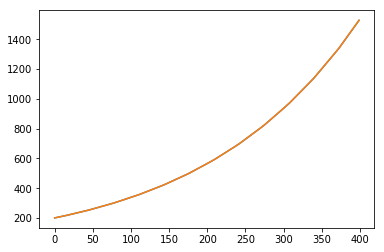

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.squeeze(for_check['SCC2_FK_base']))
plt.plot(SCC2_FK_base)

### Probabilities

In [ ]:
Dists = {}

a = β𝘧 - 5 * np.sqrt(σᵦ)
b = β𝘧 + 5 * np.sqrt(σᵦ)
a_10std = β𝘧 - 10 * np.sqrt(σᵦ)
b_10std = β𝘧 + 10 * np.sqrt(σᵦ)
beta_f_space = np.linspace(a_10std,b_10std,200)

original_dist = norm.pdf(beta_f_space, β𝘧, np.sqrt(σᵦ))
Dists['Original'] = original_dist

R_value = np.mean(hists[:,0,:], axis = 1)
K_value = np.mean(hists[:,1,:], axis = 1)
F_value = np.mean(hists[:,2,:], axis = 1)

R_func_r = []
R_func = []
β̃_func_r = []
β̃_func = []
λ̃_func_r = []
λ̃_func = []
for ite in range(len(R_)):
    R_func_r.append(GridInterp(gridpoints, R_[ite], method))
    R_func.append(lambda x, ite = ite: R_func_r[ite].get_value(np.log(x[0]), x[2], np.log(x[1])))
    β̃_func_r.append(GridInterp(gridpoints, β̃_[ite], method))
    β̃_func.append(lambda x, ite = ite: β̃_func_r[ite].get_value(np.log(x[0]), x[2], np.log(x[1])))
    λ̃_func_r.append(GridInterp(gridpoints, λ̃_[ite], method))
    λ̃_func.append(lambda x, ite = ite: λ̃_func_r[ite].get_value(np.log(x[0]), x[2], np.log(x[1])))

hists_mean = np.mean(hists, axis = 2)
RE_plot = np.zeros(pers)
weight_plot = [np.zeros([pers,1]) for ite in range(len(π̃_norm_func))]
for tm in range(pers):
    RE_plot[tm] = RE_func(hists_mean[tm,:])
    for ite in range(len(π̃_norm_func)):
        weight_plot[ite][tm] = π̃_norm_func[ite](hists_mean[tm,:])

for tm in [1,100,200,300,400]:
    R0 = hists[tm-1,0,0]
    K0 = hists[tm-1,1,0]
    F0 = hists[tm-1,2,0]
    weights_prob = []
    mean_distort_ = []
    lambda_tilde_ = []
    tilt_dist_ = []
    
    for ite in range(len(π̃_norm_func)):
        weights_prob.append(π̃_norm_func[ite]([R0, K0, F0]))
        mean_distort_.append(β̃_func[ite]([R0, K0, F0]) - βf)
        lambda_tilde_.append(λ̃_func[ite]([R0, K0, F0]))
        tilt_dist_.append(norm.pdf(beta_f_space, mean_distort_[ite] + βf, 1 / np.sqrt(lambda_tilde_[ite])))
        
    weighted = sum(w * til for w, til in zip(weights_prob, tilt_dist_) )
    Dists['Year' + str(int((tm) / 4))] = dict(tilt_dist = tilt_dist_, weighted = weighted, weights = weights_prob)

In [ ]:
for_check = loadmat('./MATLAB_Data/Dist_50yr.mat')
np.max(abs(for_check['weighted'] - Dists['Year50']['weighted']))

In [ ]:
Dists['Year100']['weighted']

In [ ]:
max([1,2,3,4,5,6,7]) < 5

In [ ]:
np.c_[for_check['RE_plot'][0], RE_plot]